<a href="https://colab.research.google.com/github/mmaruthi/S5-Assignment-Solution/blob/master/step15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


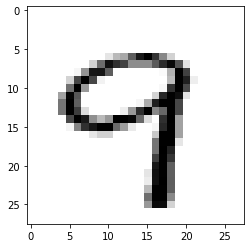

In [6]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

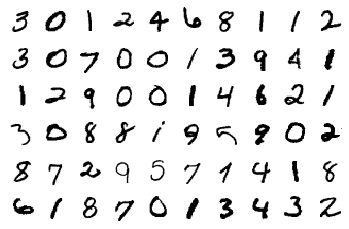

In [7]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(0.2),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(0.2),
            nn.ReLU()
        ) # output_size = 24

                # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(0.2),
            nn.ReLU()
        ) # output_size = 10

        # TRANSITION BLOCK 1
        #self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        #self.convblock4 = nn.Sequential(
         #   nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            
            
        #    nn.ReLU()
        #) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(0.2),
            nn.ReLU()
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 6

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(0.2),
            nn.ReLU()
        ) # output_size = 6
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(6, 6), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        #x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        #x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        #x = self.convblock7(x)
        #x = self.convblock8(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [17]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
           Dropout-3           [-1, 10, 26, 26]               0
              ReLU-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
       BatchNorm2d-6           [-1, 10, 24, 24]              20
           Dropout-7           [-1, 10, 24, 24]               0
              ReLU-8           [-1, 10, 24, 24]               0
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 20, 10, 10]           1,800
      BatchNorm2d-11           [-1, 20, 10, 10]              40
          Dropout-12           [-1, 20, 10, 10]               0
             ReLU-13           [-1, 20, 10, 10]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [19]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0



Loss=2.313274383544922 Batch_id=0 Accuracy=7.03:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=2.313274383544922 Batch_id=0 Accuracy=7.03:   0%|          | 1/469 [00:00<02:11,  3.56it/s]
Loss=2.321096181869507 Batch_id=1 Accuracy=8.20:   0%|          | 1/469 [00:00<02:11,  3.56it/s]
Loss=2.3459715843200684 Batch_id=2 Accuracy=8.07:   0%|          | 1/469 [00:00<02:11,  3.56it/s]
Loss=2.306185245513916 Batch_id=3 Accuracy=9.57:   0%|          | 1/469 [00:00<02:11,  3.56it/s] 
Loss=2.2832467555999756 Batch_id=4 Accuracy=9.53:   0%|          | 1/469 [00:00<02:11,  3.56it/s]
Loss=2.2832467555999756 Batch_id=4 Accuracy=9.53:   1%|          | 5/469 [00:00<01:34,  4.89it/s]
Loss=2.2712972164154053 Batch_id=5 Accuracy=9.77:   1%|          | 5/469 [00:00<01:34,  4.89it/s]
Loss=2.2572336196899414 Batch_id=6 Accuracy=10.60:   1%|          | 5/469 [00:00<01:34,  4.89it/s]
Loss=2.254728317260742 Batch_id=7 Accuracy=11.23:   1%|          | 5/469 [00:00<01:34,  4.89it/s] 
Loss=2.222858190536499 Batch


Test set: Average loss: 0.5304, Accuracy: 8693/10000 (86.93%)

EPOCH: 1



Loss=0.34677231311798096 Batch_id=0 Accuracy=92.19:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.34677231311798096 Batch_id=0 Accuracy=92.19:   0%|          | 1/469 [00:00<02:12,  3.52it/s]
Loss=0.3958439230918884 Batch_id=1 Accuracy=91.80:   0%|          | 1/469 [00:00<02:12,  3.52it/s] 
Loss=0.33688241243362427 Batch_id=2 Accuracy=93.23:   0%|          | 1/469 [00:00<02:12,  3.52it/s]
Loss=0.3724808692932129 Batch_id=3 Accuracy=92.77:   0%|          | 1/469 [00:00<02:12,  3.52it/s] 
Loss=0.36643198132514954 Batch_id=4 Accuracy=92.66:   0%|          | 1/469 [00:00<02:12,  3.52it/s]
Loss=0.31110960245132446 Batch_id=5 Accuracy=92.97:   0%|          | 1/469 [00:00<02:12,  3.52it/s]
Loss=0.31110960245132446 Batch_id=5 Accuracy=92.97:   1%|▏         | 6/469 [00:00<01:35,  4.86it/s]
Loss=0.34774893522262573 Batch_id=6 Accuracy=93.30:   1%|▏         | 6/469 [00:00<01:35,  4.86it/s]
Loss=0.3699268400669098 Batch_id=7 Accuracy=93.36:   1%|▏         | 6/469 [00:00<01:35,  4.86it/s] 
Loss=0.


Test set: Average loss: 0.2666, Accuracy: 9341/10000 (93.41%)

EPOCH: 2



Loss=0.24906133115291595 Batch_id=0 Accuracy=96.09:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.24906133115291595 Batch_id=0 Accuracy=96.09:   0%|          | 1/469 [00:00<01:59,  3.90it/s]
Loss=0.16920363903045654 Batch_id=1 Accuracy=96.09:   0%|          | 1/469 [00:00<01:59,  3.90it/s]
Loss=0.2087826430797577 Batch_id=2 Accuracy=95.57:   0%|          | 1/469 [00:00<01:59,  3.90it/s] 
Loss=0.23987074196338654 Batch_id=3 Accuracy=95.12:   0%|          | 1/469 [00:00<01:59,  3.90it/s]
Loss=0.1838253289461136 Batch_id=4 Accuracy=95.47:   0%|          | 1/469 [00:00<01:59,  3.90it/s] 
Loss=0.2213289439678192 Batch_id=5 Accuracy=95.31:   0%|          | 1/469 [00:00<01:59,  3.90it/s]
Loss=0.241084486246109 Batch_id=6 Accuracy=95.31:   0%|          | 1/469 [00:00<01:59,  3.90it/s] 
Loss=0.22795556485652924 Batch_id=7 Accuracy=95.12:   0%|          | 1/469 [00:00<01:59,  3.90it/s]
Loss=0.22795556485652924 Batch_id=7 Accuracy=95.12:   2%|▏         | 8/469 [00:00<01:25,  5.42it/s]
Loss=0.15


Test set: Average loss: 0.2198, Accuracy: 9410/10000 (94.10%)

EPOCH: 3



Loss=0.13270984590053558 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.13270984590053558 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<02:06,  3.71it/s]
Loss=0.14624859392642975 Batch_id=1 Accuracy=96.88:   0%|          | 1/469 [00:00<02:06,  3.71it/s]
Loss=0.27011799812316895 Batch_id=2 Accuracy=95.83:   0%|          | 1/469 [00:00<02:06,  3.71it/s]
Loss=0.1249217763543129 Batch_id=3 Accuracy=96.29:   0%|          | 1/469 [00:00<02:06,  3.71it/s] 
Loss=0.1459546983242035 Batch_id=4 Accuracy=96.41:   0%|          | 1/469 [00:00<02:06,  3.71it/s]
Loss=0.1459546983242035 Batch_id=4 Accuracy=96.41:   1%|          | 5/469 [00:00<01:31,  5.09it/s]
Loss=0.17041625082492828 Batch_id=5 Accuracy=96.22:   1%|          | 5/469 [00:00<01:31,  5.09it/s]
Loss=0.13900046050548553 Batch_id=6 Accuracy=96.21:   1%|          | 5/469 [00:00<01:31,  5.09it/s]
Loss=0.16089670360088348 Batch_id=7 Accuracy=96.39:   1%|          | 5/469 [00:00<01:31,  5.09it/s]
Loss=0.15


Test set: Average loss: 0.1796, Accuracy: 9522/10000 (95.22%)

EPOCH: 4



Loss=0.13924792408943176 Batch_id=0 Accuracy=96.88:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.13924792408943176 Batch_id=0 Accuracy=96.88:   0%|          | 1/469 [00:00<01:48,  4.33it/s]
Loss=0.09426571428775787 Batch_id=1 Accuracy=97.66:   0%|          | 1/469 [00:00<01:48,  4.33it/s]
Loss=0.1653076410293579 Batch_id=2 Accuracy=97.14:   0%|          | 1/469 [00:00<01:48,  4.33it/s] 
Loss=0.0685398131608963 Batch_id=3 Accuracy=97.46:   0%|          | 1/469 [00:00<01:48,  4.33it/s]
Loss=0.17320796847343445 Batch_id=4 Accuracy=97.03:   0%|          | 1/469 [00:00<01:48,  4.33it/s]
Loss=0.17320796847343445 Batch_id=4 Accuracy=97.03:   1%|          | 5/469 [00:00<01:19,  5.83it/s]
Loss=0.14051774144172668 Batch_id=5 Accuracy=97.14:   1%|          | 5/469 [00:00<01:19,  5.83it/s]
Loss=0.1544264405965805 Batch_id=6 Accuracy=96.99:   1%|          | 5/469 [00:00<01:19,  5.83it/s] 
Loss=0.19060635566711426 Batch_id=7 Accuracy=96.48:   1%|          | 5/469 [00:00<01:19,  5.83it/s]
Loss=0.0


Test set: Average loss: 0.1613, Accuracy: 9555/10000 (95.55%)

EPOCH: 5



Loss=0.10190199315547943 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.10190199315547943 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<01:46,  4.39it/s]
Loss=0.1055164486169815 Batch_id=1 Accuracy=97.27:   0%|          | 1/469 [00:00<01:46,  4.39it/s] 
Loss=0.1121813952922821 Batch_id=2 Accuracy=97.14:   0%|          | 1/469 [00:00<01:46,  4.39it/s]
Loss=0.11518901586532593 Batch_id=3 Accuracy=96.88:   0%|          | 1/469 [00:00<01:46,  4.39it/s]
Loss=0.11027640849351883 Batch_id=4 Accuracy=97.19:   0%|          | 1/469 [00:00<01:46,  4.39it/s]
Loss=0.11027640849351883 Batch_id=4 Accuracy=97.19:   1%|          | 5/469 [00:00<01:17,  5.96it/s]
Loss=0.15290868282318115 Batch_id=5 Accuracy=97.01:   1%|          | 5/469 [00:00<01:17,  5.96it/s]
Loss=0.15260939300060272 Batch_id=6 Accuracy=96.65:   1%|          | 5/469 [00:00<01:17,  5.96it/s]
Loss=0.1149321123957634 Batch_id=7 Accuracy=96.78:   1%|          | 5/469 [00:00<01:17,  5.96it/s] 
Loss=0.1


Test set: Average loss: 0.1526, Accuracy: 9557/10000 (95.57%)

EPOCH: 6



Loss=0.12981362640857697 Batch_id=0 Accuracy=95.31:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.12981362640857697 Batch_id=0 Accuracy=95.31:   0%|          | 1/469 [00:00<01:49,  4.26it/s]
Loss=0.1613825261592865 Batch_id=1 Accuracy=95.31:   0%|          | 1/469 [00:00<01:49,  4.26it/s] 
Loss=0.10148483514785767 Batch_id=2 Accuracy=95.83:   0%|          | 1/469 [00:00<01:49,  4.26it/s]
Loss=0.12545526027679443 Batch_id=3 Accuracy=96.48:   0%|          | 1/469 [00:00<01:49,  4.26it/s]
Loss=0.10887844860553741 Batch_id=4 Accuracy=96.41:   0%|          | 1/469 [00:00<01:49,  4.26it/s]
Loss=0.11993265151977539 Batch_id=5 Accuracy=96.35:   0%|          | 1/469 [00:00<01:49,  4.26it/s]
Loss=0.11993265151977539 Batch_id=5 Accuracy=96.35:   1%|▏         | 6/469 [00:00<01:19,  5.85it/s]
Loss=0.17958860099315643 Batch_id=6 Accuracy=96.21:   1%|▏         | 6/469 [00:00<01:19,  5.85it/s]
Loss=0.10510386526584625 Batch_id=7 Accuracy=96.19:   1%|▏         | 6/469 [00:00<01:19,  5.85it/s]
Loss=0.


Test set: Average loss: 0.1398, Accuracy: 9607/10000 (96.07%)

EPOCH: 7



Loss=0.1185411810874939 Batch_id=0 Accuracy=96.09:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.1185411810874939 Batch_id=0 Accuracy=96.09:   0%|          | 1/469 [00:00<02:02,  3.81it/s]
Loss=0.18086668848991394 Batch_id=1 Accuracy=95.70:   0%|          | 1/469 [00:00<02:02,  3.81it/s]
Loss=0.07481865584850311 Batch_id=2 Accuracy=96.61:   0%|          | 1/469 [00:00<02:02,  3.81it/s]
Loss=0.11775116622447968 Batch_id=3 Accuracy=96.68:   0%|          | 1/469 [00:00<02:02,  3.81it/s]
Loss=0.0969734787940979 Batch_id=4 Accuracy=96.72:   0%|          | 1/469 [00:00<02:02,  3.81it/s] 
Loss=0.22326283156871796 Batch_id=5 Accuracy=95.70:   0%|          | 1/469 [00:00<02:02,  3.81it/s]
Loss=0.22326283156871796 Batch_id=5 Accuracy=95.70:   1%|▏         | 6/469 [00:00<01:28,  5.24it/s]
Loss=0.14471293985843658 Batch_id=6 Accuracy=95.54:   1%|▏         | 6/469 [00:00<01:28,  5.24it/s]
Loss=0.08842293918132782 Batch_id=7 Accuracy=95.90:   1%|▏         | 6/469 [00:00<01:28,  5.24it/s]
Loss=0.07


Test set: Average loss: 0.1154, Accuracy: 9668/10000 (96.68%)

EPOCH: 8



Loss=0.13349460065364838 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.13349460065364838 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<01:53,  4.11it/s]
Loss=0.06737768650054932 Batch_id=1 Accuracy=98.44:   0%|          | 1/469 [00:00<01:53,  4.11it/s]
Loss=0.12961766123771667 Batch_id=2 Accuracy=97.66:   0%|          | 1/469 [00:00<01:53,  4.11it/s]
Loss=0.06776644289493561 Batch_id=3 Accuracy=98.05:   0%|          | 1/469 [00:00<01:53,  4.11it/s]
Loss=0.08705313503742218 Batch_id=4 Accuracy=97.97:   0%|          | 1/469 [00:00<01:53,  4.11it/s]
Loss=0.08705313503742218 Batch_id=4 Accuracy=97.97:   1%|          | 5/469 [00:00<01:22,  5.60it/s]
Loss=0.05323643982410431 Batch_id=5 Accuracy=98.18:   1%|          | 5/469 [00:00<01:22,  5.60it/s]
Loss=0.140376478433609 Batch_id=6 Accuracy=97.88:   1%|          | 5/469 [00:00<01:22,  5.60it/s]  
Loss=0.05094272643327713 Batch_id=7 Accuracy=98.05:   1%|          | 5/469 [00:00<01:22,  5.60it/s]
Loss=0.


Test set: Average loss: 0.1113, Accuracy: 9685/10000 (96.85%)

EPOCH: 9



Loss=0.07886072993278503 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.07886072993278503 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:20,  3.33it/s]
Loss=0.0644131675362587 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<02:20,  3.33it/s] 
Loss=0.09777005016803741 Batch_id=2 Accuracy=98.18:   0%|          | 1/469 [00:00<02:20,  3.33it/s]
Loss=0.07733301818370819 Batch_id=3 Accuracy=98.24:   0%|          | 1/469 [00:00<02:20,  3.33it/s]
Loss=0.10393602401018143 Batch_id=4 Accuracy=97.97:   0%|          | 1/469 [00:00<02:20,  3.33it/s]
Loss=0.08314613997936249 Batch_id=5 Accuracy=97.92:   0%|          | 1/469 [00:00<02:20,  3.33it/s]
Loss=0.08314613997936249 Batch_id=5 Accuracy=97.92:   1%|▏         | 6/469 [00:00<01:40,  4.63it/s]
Loss=0.11385755240917206 Batch_id=6 Accuracy=97.88:   1%|▏         | 6/469 [00:00<01:40,  4.63it/s]
Loss=0.07759340852499008 Batch_id=7 Accuracy=97.85:   1%|▏         | 6/469 [00:00<01:40,  4.63it/s]
Loss=0.


Test set: Average loss: 0.1309, Accuracy: 9620/10000 (96.20%)

EPOCH: 10



Loss=0.06682470440864563 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.06682470440864563 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<01:59,  3.93it/s]
Loss=0.09405283629894257 Batch_id=1 Accuracy=97.27:   0%|          | 1/469 [00:00<01:59,  3.93it/s]
Loss=0.07696384936571121 Batch_id=2 Accuracy=97.66:   0%|          | 1/469 [00:00<01:59,  3.93it/s]
Loss=0.055147912353277206 Batch_id=3 Accuracy=98.05:   0%|          | 1/469 [00:00<01:59,  3.93it/s]
Loss=0.10380921512842178 Batch_id=4 Accuracy=97.81:   0%|          | 1/469 [00:00<01:59,  3.93it/s] 
Loss=0.08470813184976578 Batch_id=5 Accuracy=97.66:   0%|          | 1/469 [00:00<01:59,  3.93it/s]
Loss=0.08470813184976578 Batch_id=5 Accuracy=97.66:   1%|▏         | 6/469 [00:00<01:25,  5.40it/s]
Loss=0.13911765813827515 Batch_id=6 Accuracy=97.43:   1%|▏         | 6/469 [00:00<01:25,  5.40it/s]
Loss=0.1386406123638153 Batch_id=7 Accuracy=97.27:   1%|▏         | 6/469 [00:00<01:25,  5.40it/s] 
Loss=


Test set: Average loss: 0.1121, Accuracy: 9681/10000 (96.81%)

EPOCH: 11



Loss=0.0866042822599411 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.0866042822599411 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<01:58,  3.93it/s]
Loss=0.0768667459487915 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<01:58,  3.93it/s]
Loss=0.09910407662391663 Batch_id=2 Accuracy=98.18:   0%|          | 1/469 [00:00<01:58,  3.93it/s]
Loss=0.08333516120910645 Batch_id=3 Accuracy=98.05:   0%|          | 1/469 [00:00<01:58,  3.93it/s]
Loss=0.10584813356399536 Batch_id=4 Accuracy=97.97:   0%|          | 1/469 [00:00<01:58,  3.93it/s]
Loss=0.10584813356399536 Batch_id=4 Accuracy=97.97:   1%|          | 5/469 [00:00<01:26,  5.37it/s]
Loss=0.037816017866134644 Batch_id=5 Accuracy=98.05:   1%|          | 5/469 [00:00<01:26,  5.37it/s]
Loss=0.12098279595375061 Batch_id=6 Accuracy=97.88:   1%|          | 5/469 [00:00<01:26,  5.37it/s] 
Loss=0.06493055820465088 Batch_id=7 Accuracy=97.95:   1%|          | 5/469 [00:00<01:26,  5.37it/s]
Loss=0.1


Test set: Average loss: 0.1043, Accuracy: 9710/10000 (97.10%)

EPOCH: 12



Loss=0.11259251832962036 Batch_id=0 Accuracy=96.88:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.11259251832962036 Batch_id=0 Accuracy=96.88:   0%|          | 1/469 [00:00<01:58,  3.94it/s]
Loss=0.04030270129442215 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<01:58,  3.94it/s]
Loss=0.13818056881427765 Batch_id=2 Accuracy=97.66:   0%|          | 1/469 [00:00<01:58,  3.94it/s]
Loss=0.05206165090203285 Batch_id=3 Accuracy=98.05:   0%|          | 1/469 [00:00<01:58,  3.94it/s]
Loss=0.05592384561896324 Batch_id=4 Accuracy=98.28:   0%|          | 1/469 [00:00<01:58,  3.94it/s]
Loss=0.05592384561896324 Batch_id=4 Accuracy=98.28:   1%|          | 5/469 [00:00<01:26,  5.37it/s]
Loss=0.07682732492685318 Batch_id=5 Accuracy=98.18:   1%|          | 5/469 [00:00<01:26,  5.37it/s]
Loss=0.0695759654045105 Batch_id=6 Accuracy=98.10:   1%|          | 5/469 [00:00<01:26,  5.37it/s] 
Loss=0.09518487006425858 Batch_id=7 Accuracy=98.05:   1%|          | 5/469 [00:00<01:26,  5.37it/s]
Loss=0.


Test set: Average loss: 0.1212, Accuracy: 9644/10000 (96.44%)

EPOCH: 13



Loss=0.0641392320394516 Batch_id=0 Accuracy=96.88:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.0641392320394516 Batch_id=0 Accuracy=96.88:   0%|          | 1/469 [00:00<01:32,  5.08it/s]
Loss=0.05509963631629944 Batch_id=1 Accuracy=97.27:   0%|          | 1/469 [00:00<01:32,  5.08it/s]
Loss=0.061049774289131165 Batch_id=2 Accuracy=97.66:   0%|          | 1/469 [00:00<01:32,  5.08it/s]
Loss=0.061049774289131165 Batch_id=2 Accuracy=97.66:   1%|          | 3/469 [00:00<01:12,  6.44it/s]
Loss=0.09551403671503067 Batch_id=3 Accuracy=97.46:   1%|          | 3/469 [00:00<01:12,  6.44it/s] 
Loss=0.06057360768318176 Batch_id=4 Accuracy=97.66:   1%|          | 3/469 [00:00<01:12,  6.44it/s]
Loss=0.11541324853897095 Batch_id=5 Accuracy=97.53:   1%|          | 3/469 [00:00<01:12,  6.44it/s]
Loss=0.05654299631714821 Batch_id=6 Accuracy=97.77:   1%|          | 3/469 [00:00<01:12,  6.44it/s]
Loss=0.05654299631714821 Batch_id=6 Accuracy=97.77:   1%|▏         | 7/469 [00:00<00:53,  8.57it/s]
Loss=0


Test set: Average loss: 0.0805, Accuracy: 9771/10000 (97.71%)

EPOCH: 14



Loss=0.043169498443603516 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.043169498443603516 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<01:45,  4.42it/s]
Loss=0.08124636113643646 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<01:45,  4.42it/s] 
Loss=0.0867128074169159 Batch_id=2 Accuracy=98.18:   0%|          | 1/469 [00:00<01:45,  4.42it/s] 
Loss=0.0918845683336258 Batch_id=3 Accuracy=98.05:   0%|          | 1/469 [00:00<01:45,  4.42it/s]
Loss=0.0918845683336258 Batch_id=3 Accuracy=98.05:   1%|          | 4/469 [00:00<01:19,  5.85it/s]
Loss=0.04707685858011246 Batch_id=4 Accuracy=98.44:   1%|          | 4/469 [00:00<01:19,  5.85it/s]
Loss=0.05790334939956665 Batch_id=5 Accuracy=98.44:   1%|          | 4/469 [00:00<01:19,  5.85it/s]
Loss=0.11700627952814102 Batch_id=6 Accuracy=98.10:   1%|          | 4/469 [00:00<01:19,  5.85it/s]
Loss=0.06875938177108765 Batch_id=7 Accuracy=98.14:   1%|          | 4/469 [00:00<01:19,  5.85it/s]
Loss=0


Test set: Average loss: 0.0904, Accuracy: 9748/10000 (97.48%)

EPOCH: 15



Loss=0.042237769812345505 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.042237769812345505 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:09,  3.61it/s]
Loss=0.07232260704040527 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<02:09,  3.61it/s] 
Loss=0.17778415977954865 Batch_id=2 Accuracy=96.61:   0%|          | 1/469 [00:00<02:09,  3.61it/s]
Loss=0.0805359035730362 Batch_id=3 Accuracy=96.68:   0%|          | 1/469 [00:00<02:09,  3.61it/s] 
Loss=0.1419445276260376 Batch_id=4 Accuracy=96.25:   0%|          | 1/469 [00:00<02:09,  3.61it/s]
Loss=0.14645257592201233 Batch_id=5 Accuracy=96.09:   0%|          | 1/469 [00:00<02:09,  3.61it/s]
Loss=0.14645257592201233 Batch_id=5 Accuracy=96.09:   1%|▏         | 6/469 [00:00<01:32,  4.98it/s]
Loss=0.1272260546684265 Batch_id=6 Accuracy=95.98:   1%|▏         | 6/469 [00:00<01:32,  4.98it/s] 
Loss=0.05686661973595619 Batch_id=7 Accuracy=96.19:   1%|▏         | 6/469 [00:00<01:32,  4.98it/s]
Loss=


Test set: Average loss: 0.1069, Accuracy: 9692/10000 (96.92%)

EPOCH: 16



Loss=0.11874781548976898 Batch_id=0 Accuracy=95.31:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.11874781548976898 Batch_id=0 Accuracy=95.31:   0%|          | 1/469 [00:00<01:58,  3.95it/s]
Loss=0.0862797275185585 Batch_id=1 Accuracy=96.88:   0%|          | 1/469 [00:00<01:58,  3.95it/s] 
Loss=0.05760302394628525 Batch_id=2 Accuracy=97.40:   0%|          | 1/469 [00:00<01:58,  3.95it/s]
Loss=0.040810324251651764 Batch_id=3 Accuracy=97.85:   0%|          | 1/469 [00:00<01:58,  3.95it/s]
Loss=0.04573696106672287 Batch_id=4 Accuracy=98.12:   0%|          | 1/469 [00:00<01:58,  3.95it/s] 
Loss=0.07618410885334015 Batch_id=5 Accuracy=97.92:   0%|          | 1/469 [00:00<01:58,  3.95it/s]
Loss=0.07618410885334015 Batch_id=5 Accuracy=97.92:   1%|▏         | 6/469 [00:00<01:25,  5.42it/s]
Loss=0.047704488039016724 Batch_id=6 Accuracy=98.10:   1%|▏         | 6/469 [00:00<01:25,  5.42it/s]
Loss=0.0757085382938385 Batch_id=7 Accuracy=98.05:   1%|▏         | 6/469 [00:00<01:25,  5.42it/s]  
Los


Test set: Average loss: 0.1095, Accuracy: 9680/10000 (96.80%)

EPOCH: 17



Loss=0.11371662467718124 Batch_id=0 Accuracy=96.09:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.11371662467718124 Batch_id=0 Accuracy=96.09:   0%|          | 1/469 [00:00<02:12,  3.53it/s]
Loss=0.08231119811534882 Batch_id=1 Accuracy=97.27:   0%|          | 1/469 [00:00<02:12,  3.53it/s]
Loss=0.09288571774959564 Batch_id=2 Accuracy=97.40:   0%|          | 1/469 [00:00<02:12,  3.53it/s]
Loss=0.060531582683324814 Batch_id=3 Accuracy=97.27:   0%|          | 1/469 [00:00<02:12,  3.53it/s]
Loss=0.08620594441890717 Batch_id=4 Accuracy=97.50:   0%|          | 1/469 [00:00<02:12,  3.53it/s] 
Loss=0.10269313305616379 Batch_id=5 Accuracy=97.53:   0%|          | 1/469 [00:00<02:12,  3.53it/s]
Loss=0.10269313305616379 Batch_id=5 Accuracy=97.53:   1%|▏         | 6/469 [00:00<01:34,  4.88it/s]
Loss=0.17937159538269043 Batch_id=6 Accuracy=96.99:   1%|▏         | 6/469 [00:00<01:34,  4.88it/s]
Loss=0.059195928275585175 Batch_id=7 Accuracy=97.27:   1%|▏         | 6/469 [00:00<01:34,  4.88it/s]
Loss


Test set: Average loss: 0.0970, Accuracy: 9725/10000 (97.25%)

EPOCH: 18



Loss=0.09298381954431534 Batch_id=0 Accuracy=96.09:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.09298381954431534 Batch_id=0 Accuracy=96.09:   0%|          | 1/469 [00:00<02:09,  3.60it/s]
Loss=0.03682921081781387 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<02:09,  3.60it/s]
Loss=0.03334647789597511 Batch_id=2 Accuracy=98.70:   0%|          | 1/469 [00:00<02:09,  3.60it/s]
Loss=0.15193164348602295 Batch_id=3 Accuracy=98.05:   0%|          | 1/469 [00:00<02:09,  3.60it/s]
Loss=0.11633993685245514 Batch_id=4 Accuracy=97.34:   0%|          | 1/469 [00:00<02:09,  3.60it/s]
Loss=0.11633993685245514 Batch_id=4 Accuracy=97.34:   1%|          | 5/469 [00:00<01:33,  4.94it/s]
Loss=0.040999434888362885 Batch_id=5 Accuracy=97.66:   1%|          | 5/469 [00:00<01:33,  4.94it/s]
Loss=0.03374386578798294 Batch_id=6 Accuracy=97.77:   1%|          | 5/469 [00:00<01:33,  4.94it/s] 
Loss=0.05150993913412094 Batch_id=7 Accuracy=97.85:   1%|          | 5/469 [00:00<01:33,  4.94it/s]
Loss=


Test set: Average loss: 0.0915, Accuracy: 9734/10000 (97.34%)

EPOCH: 19



Loss=0.09380806237459183 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.09380806237459183 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<01:58,  3.94it/s]
Loss=0.10959407687187195 Batch_id=1 Accuracy=97.27:   0%|          | 1/469 [00:00<01:58,  3.94it/s]
Loss=0.06629388779401779 Batch_id=2 Accuracy=97.66:   0%|          | 1/469 [00:00<01:58,  3.94it/s]
Loss=0.047831129282712936 Batch_id=3 Accuracy=97.85:   0%|          | 1/469 [00:00<01:58,  3.94it/s]
Loss=0.03604505956172943 Batch_id=4 Accuracy=98.28:   0%|          | 1/469 [00:00<01:58,  3.94it/s] 
Loss=0.04905809834599495 Batch_id=5 Accuracy=98.44:   0%|          | 1/469 [00:00<01:58,  3.94it/s]
Loss=0.04905809834599495 Batch_id=5 Accuracy=98.44:   1%|▏         | 6/469 [00:00<01:25,  5.41it/s]
Loss=0.041390761733055115 Batch_id=6 Accuracy=98.55:   1%|▏         | 6/469 [00:00<01:25,  5.41it/s]
Loss=0.05865095183253288 Batch_id=7 Accuracy=98.44:   1%|▏         | 6/469 [00:00<01:25,  5.41it/s] 
Los


Test set: Average loss: 0.0886, Accuracy: 9727/10000 (97.27%)



Text(0.5, 1.0, 'Test Accuracy')

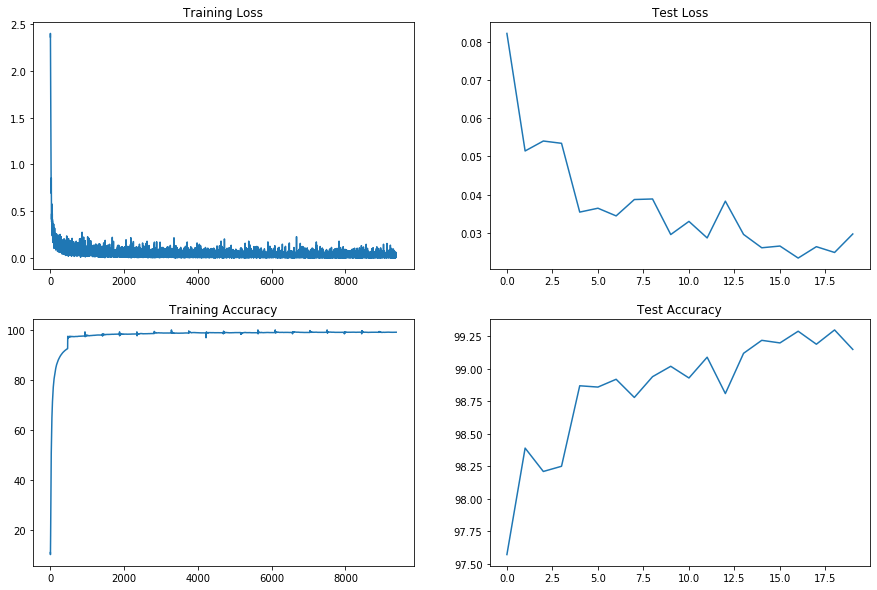

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")